In [1]:
# load both dataframes
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

original_df = pd.read_csv("./spreadsheets/reflacx_clinical.csv")
original_clinical_cols = [
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    'age',
    'gender'
]
chexpert_label_cols = [col for col in original_df if col.endswith("chexpert")]


In [2]:
identified_keywords = {
    "pulmonary consolidation": {
        "boolean": [
            "area of white lung on x-ray",
            "bronchial breath sounds",
            "impaired percussion note",
            "increased vocal fremitus",
            "increased vocal resonance",
            "lower pao2 than calculated in the alveolar gas equation",
            "possible crackles",
            "possible presence of a pleural rub",
            "reduced expansion of the thorax on inspiration",
        ],
        "numerical": [],
    },
    "pleural abnormality": {
        "boolean": [
            "bone fractures",
            "heart failure",
            "hiatal hernia",
            "interstitial lung disease",
            "plaques",
            "pleural effusions",
            "pleural thickening",
            "pneumonia",
            "pneumothorax",
            "pulmonary tuberculosis",
        ],
        "numerical": [],
    },
    "enlarged cardiac silhouette": {
        "boolean": [
            "anxiety",
            "back pain",
            "cardiac tamponade",
            "decreased alertness",
            "diaphoresis",
            "distant heart sounds",
            "distension of the jugular vein",
            "dry cough",
            "electrical alternans on ekg",
            "electrical alternans on holter monitor",
            "fatigue",
            "fever",
            "fluid around the heart",
            "friction rub",
            "left precordial pleuritic chest pain",
            "neck pain",
            "pain in the shoulders",
            "palpitations",  # can be heart-rate. (increased heart-rate)
            "pericardial effusion",
            "positional chest pain",
            "pulsus paradoxus",
            "radiation to the trapezius ridge",
            "relief of pain by bending forward",
            "relief of pain by sitting up",
            "shortness of breath",
            "specific electrocardiogram (ecg) changes",
            "substernal pain",
            "sudden onset of sharp chest pain",
            "weakness",
            "worsening of pain by inspiration",
            "worsening of pain by lying down",
        ],
        "numerical": [
            "systolic blood pressure (mmHg)",  # "low blood pressure"
            "diastolic blood pressure (mmHg)",  # "equilibration of diastolic blood pressures",
        ],
    },
    "pulmonary edema": {
        "boolean": [
            "chest pain",
            "congestive heart failure",
            "coughing",
            "dyspnea",
            "frothy sputum",
            "heart valve dysfunction",
            "hypertensive crisis",
            "hypoxemia",
            "impaired gas exchange",
            "impaired left ventricular function",
            "increased microvascular permeability",
            "pericardial tamponade",
            "respiratory failure",
            "volume overload",
            "wheezing",
        ],
        "numerical": [],
    },
    "atelectasis": {
        "boolean": [
            "anesthesia",
            "asthma",
            "asymptomatic",
            "breathing difficulty",
            "chest pain",
            "chronic obstructive pulmonary disease",
            "cough",
            "cyanosis",
            "fever",
            "pleural effusion",
            "pulmonary tuberculosis",
            "small volume linear shadows",
            "smoking",
        ],
        "numerical": [
            "heart rate (per minute)",  # increased heart-rate.
            "oxygen saturation (%)",  # reduced oxygen saturation.
        ],
    },
}

merged_df = None
auged_features = []
for l in identified_keywords.keys():
    lesion_df = pd.read_csv(f"./whole_dataset/{l}-feature-extension.csv")
    if merged_df is None:
        merged_df = lesion_df 
    else:
        l_features = identified_keywords[l]['boolean'] + identified_keywords[l]['numerical']
        auged_features.extend(l_features)
        for f in l_features:
            merged_df[f] = None
            merged_df[f] = lesion_df[f]

extended_clinical_features = original_clinical_cols + auged_features

In [3]:
from collections import OrderedDict
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
import torch

def get_acc_auc(df, input_cols, label_cols, cls):
    cls = cls.fit(
        df[df["split"] == "train"][input_cols],
        df[df["split"] == "train"][label_cols],
    )

    pred = cls.predict(df[df["split"] == "test"][input_cols])

    mla = MultilabelAccuracy(num_labels=len(chexpert_label_cols), average="micro")
    acc = mla(
        torch.tensor(pred),
        (
            torch.tensor(np.array(df[df["split"] == "test"][chexpert_label_cols] > 0))
        ).float(),
    )

    ml_auroc = MultilabelAUROC(num_labels=len(chexpert_label_cols), average="micro")
    auc = ml_auroc(
        torch.tensor(pred),
        (
            torch.tensor(np.array(df[df["split"] == "test"][chexpert_label_cols] > 0))
        ).long(),
    )

    feature_importance_dict = OrderedDict({
        c: i for c, i in zip(input_cols, cls.feature_importances_)
    })
    return feature_importance_dict, acc, auc

def get_important_features(fi):
    return [k for k in fi.keys() if fi[k] > fi['dummy']]
 

In [4]:
# pre-processing label cols.
for l in chexpert_label_cols:
    original_df[l] = (original_df[l] > 0).astype(float)
    merged_df[l] = (merged_df[l] > 0).astype(float)

In [5]:
original_df['gender'] = (original_df['gender'] == "F").astype(float)
merged_df['gender'] = (merged_df['gender'] == "F").astype(float)

In [6]:
# add dummy cols
original_df["dummy"] = np.random.randn(len(original_df))
merged_df["dummy"] = np.random.randn(len(merged_df))

In [7]:
def get_summary(df, input_cols, label_cols, cls_fn, r=10):
    fis = []
    accs = []
    aucs = []

    for _ in range(r):
        cls = cls_fn()
        fi, acc, auc = get_acc_auc(
            df,
            input_cols,
            label_cols,
            cls,
        )
        fis.append(fi)
        accs.append(acc)
        aucs.append(auc)

    avg_fis = OrderedDict({})
    for k in fis[0].keys():
        avg_fis[k] = np.array([fi_[k] for fi_ in fis]).mean()

    accs = np.array(accs)
    aucs = np.array(aucs)
    important_f = get_important_features(avg_fis)
    
    fi_fig = plt.figure(figsize=(max(10, len(avg_fis)*0.5), 5))
    plt.bar(
        list(avg_fis.keys()),
        list(avg_fis.values()),
    )
    plt.setp(fi_fig.axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

    return {
        "accuracy_mean": accs.mean(),
        "accuracy_std": accs.std(),
        "AUC_mean": aucs.mean(),
        "AUC_std": aucs.std(),
        "fi_df": pd.DataFrame([avg_fis]),
        "#fi>dummy": len(important_f),
        "fi>dummy": important_f,
        "fi_fig": fi_fig,
    }

In [22]:
len(original_clinical_cols)

8

In [23]:
len(list(set(extended_clinical_features)))

78

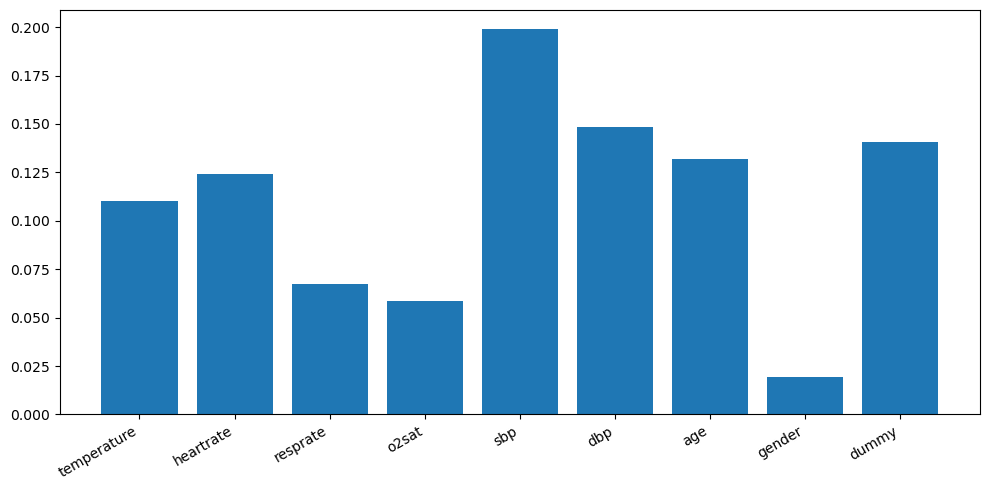

{'accuracy_mean': 0.87130946,
 'accuracy_std': 0.004531647,
 'AUC_mean': 0.6448064,
 'AUC_std': 0.009398493,
 'fi_df':    temperature  heartrate  resprate     o2sat       sbp       dbp       age  \
 0      0.11007   0.124425  0.067382  0.058614  0.198935  0.148211  0.132168   
 
      gender     dummy  
 0  0.019474  0.140719  ,
 '#fi>dummy': 2,
 'fi>dummy': ['sbp', 'dbp'],
 'fi_fig': <Figure size 1000x500 with 1 Axes>}

In [8]:
dt_result = get_summary(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    DecisionTreeClassifier,
)
dt_result

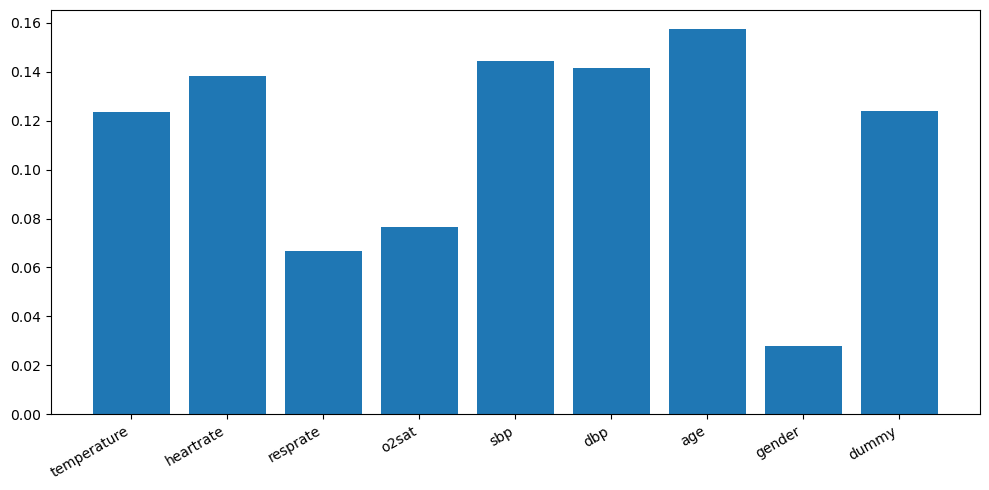

{'accuracy_mean': 0.92732155,
 'accuracy_std': 0.0011739857,
 'AUC_mean': 0.6552352,
 'AUC_std': 0.005844052,
 'fi_df':    temperature  heartrate  resprate     o2sat       sbp       dbp       age  \
 0     0.123588   0.138316  0.066685  0.076415  0.144264  0.141639  0.157293   
 
      gender     dummy  
 0  0.027916  0.123884  ,
 '#fi>dummy': 4,
 'fi>dummy': ['heartrate', 'sbp', 'dbp', 'age'],
 'fi_fig': <Figure size 1000x500 with 1 Axes>}

In [9]:
rf_result = get_summary(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier,
)
rf_result

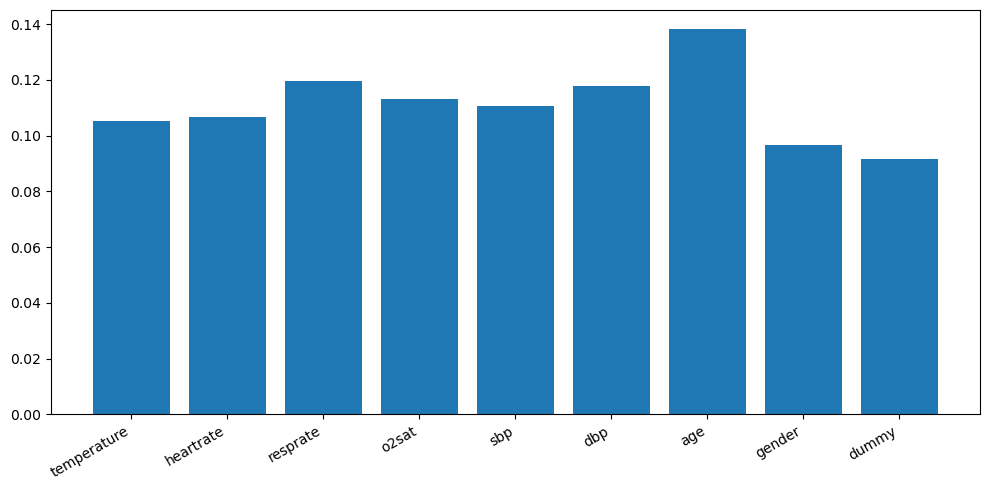

{'accuracy_mean': 0.91071427,
 'accuracy_std': 0.0,
 'AUC_mean': 0.6535478,
 'AUC_std': 0.0,
 'fi_df':    temperature  heartrate  resprate     o2sat       sbp      dbp       age  \
 0     0.105431   0.106816  0.119629  0.113006  0.110802  0.11784  0.138208   
 
      gender     dummy  
 0  0.096706  0.091563  ,
 '#fi>dummy': 8,
 'fi>dummy': ['temperature',
  'heartrate',
  'resprate',
  'o2sat',
  'sbp',
  'dbp',
  'age',
  'gender'],
 'fi_fig': <Figure size 1000x500 with 1 Axes>}

In [10]:
xgb_result = get_summary(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    xgb.XGBClassifier,
)
xgb_result

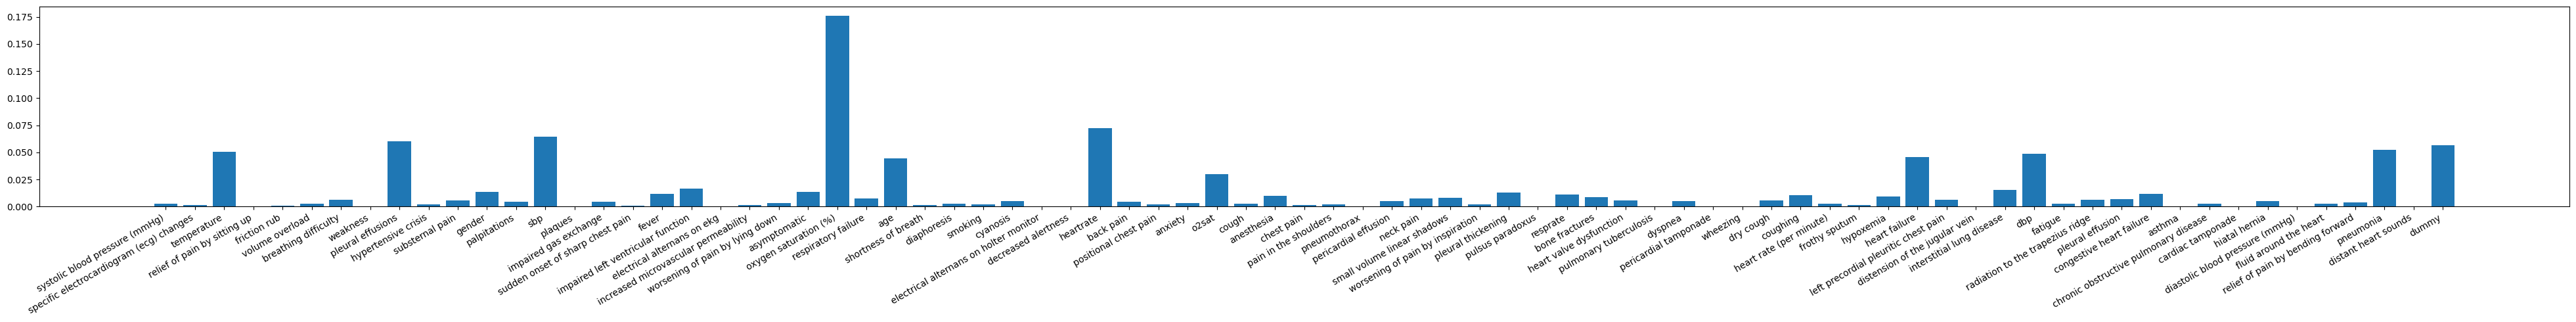

{'accuracy_mean': 0.91124994,
 'accuracy_std': 0.004304274,
 'AUC_mean': 0.75101894,
 'AUC_std': 0.008395781,
 'fi_df':    systolic blood pressure (mmHg)  specific electrocardiogram (ecg) changes  \
 0                        0.002716                                  0.001181   
 
    temperature  relief of pain by sitting up  friction rub  volume overload  \
 0     0.050499                      0.000396      0.000639         0.002474   
 
    breathing difficulty  weakness  pleural effusions  hypertensive crisis  \
 0              0.006275   0.00035           0.060235             0.002258   
 
    ...    asthma  chronic obstructive pulmonary disease  cardiac tamponade  \
 0  ...  0.000244                               0.002906           0.000326   
 
    hiatal hernia  diastolic blood pressure (mmHg)  fluid around the heart  \
 0       0.005008                         0.000274                0.002649   
 
    relief of pain by bending forward  pneumonia  distant heart sounds  \
 0     

In [11]:
aug_dt_result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    DecisionTreeClassifier,
)
aug_dt_result

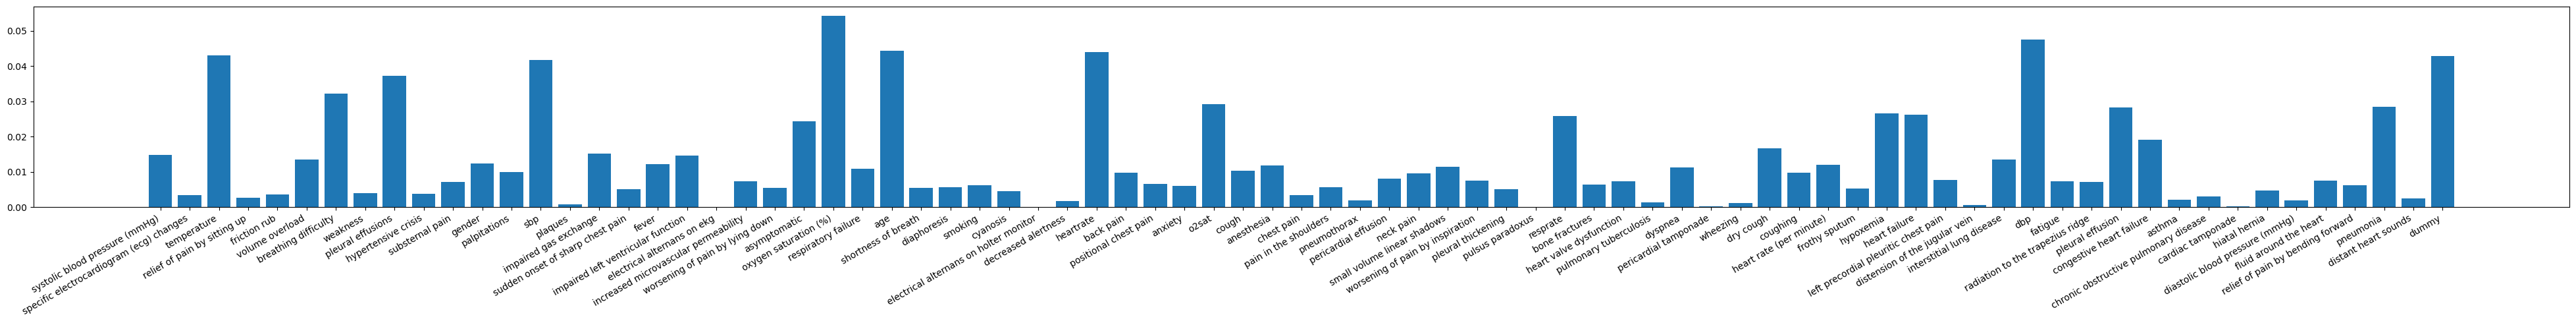

{'accuracy_mean': 0.9383928,
 'accuracy_std': 0.0015804612,
 'AUC_mean': 0.70855683,
 'AUC_std': 0.007690482,
 'fi_df':    systolic blood pressure (mmHg)  specific electrocardiogram (ecg) changes  \
 0                        0.014863                                    0.0034   
 
    temperature  relief of pain by sitting up  friction rub  volume overload  \
 0     0.043121                      0.002708      0.003704         0.013572   
 
    breathing difficulty  weakness  pleural effusions  hypertensive crisis  \
 0              0.032175  0.003938           0.037209             0.003775   
 
    ...    asthma  chronic obstructive pulmonary disease  cardiac tamponade  \
 0  ...  0.002152                               0.003033           0.000322   
 
    hiatal hernia  diastolic blood pressure (mmHg)  fluid around the heart  \
 0       0.004829                           0.0019                 0.00747   
 
    relief of pain by bending forward  pneumonia  distant heart sounds  \
 0     

In [12]:
aug_rf_result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier,
)
aug_rf_result

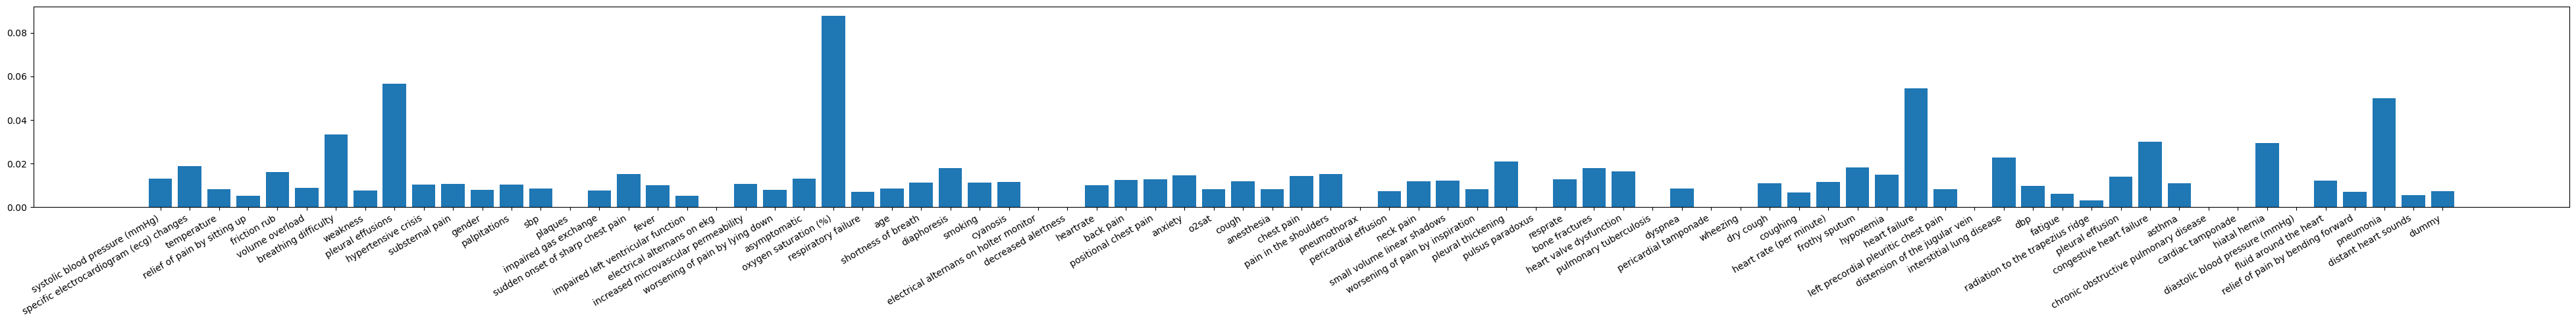

{'accuracy_mean': 0.9369048,
 'accuracy_std': 0.0,
 'AUC_mean': 0.73744166,
 'AUC_std': 0.0,
 'fi_df':    systolic blood pressure (mmHg)  specific electrocardiogram (ecg) changes  \
 0                        0.013247                                  0.018862   
 
    temperature  relief of pain by sitting up  friction rub  volume overload  \
 0     0.008151                      0.005367       0.01602         0.008935   
 
    breathing difficulty  weakness  pleural effusions  hypertensive crisis  \
 0              0.033294  0.007738           0.056708              0.01038   
 
    ...    asthma  chronic obstructive pulmonary disease  cardiac tamponade  \
 0  ...  0.011071                                    0.0                0.0   
 
    hiatal hernia  diastolic blood pressure (mmHg)  fluid around the heart  \
 0       0.029338                              0.0                0.012209   
 
    relief of pain by bending forward  pneumonia  distant heart sounds  \
 0                      

In [17]:
aug_xgb_result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    xgb.XGBClassifier,
)
aug_xgb_result